# LABORATORIUM 5 - DRZEWO DECYZYJNE

### 5.1 Implementacja drzewa decyzyjnego

In [36]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier as SkDecisionTree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons


#### Funkcja do liczenia metryk:

In [30]:
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_curve, auc

def evaluate_classifier(y_test, y_pred, X, y, model, classifier_name, dataset_name, labels=[0,1], decision_plot=True):
    # Oblicz metryki
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    accuracy = accuracy_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    # Wyświetl metryki
    print(f"{classifier_name} na {dataset_name}:")
    print(f"Skuteczność: {accuracy*100:.4f}%")
    print(f"Czułość (Recall): {sensitivity*100:.4f}%")
    print(f"Swoistość: {specificity*100:.4f}%")
    print(f"ROC AUC: {roc_auc:.4f}")

    fig = plt.figure(figsize=(20, 6))
    plt.suptitle(f"WYNIKI DLA: {classifier_name} na zbiorze: {dataset_name}", fontsize=16, y=1.05)

    axes = fig.subplots(1, 3)

    # Macierz pomyłek
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(ax=axes[0], cmap='Greens', colorbar=False)
    axes[0].set_title("Macierz pomyłek")

    # Krzywa ROC
    axes[1].plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
    axes[1].plot([0, 1], [0, 1], 'k--') 
    axes[1].set_xlabel('1 - Swoistość (False Positive Rate)')
    axes[1].set_ylabel('Czułość (True Positive Rate)')
    axes[1].set_title('Krzywa ROC')
    axes[1].legend(loc='lower right')
    axes[1].grid(True)

    if decision_plot:
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                            np.arange(y_min, y_max, 0.01))
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        custom_cmap = ListedColormap(['red', 'blue'])
        axes[2].contourf(xx, yy, Z, alpha=0.4, cmap=custom_cmap)
        scatter = axes[2].scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=custom_cmap, s=50)
        axes[2].set_title("Granica decyzyjna")
        axes[2].set_xlabel("Feature 1")
        axes[2].set_ylabel("Feature 2")
        axes[2].grid(True)

    plt.tight_layout()
    plt.show()


#### Generowanie danych:

In [51]:
def generate_data(n_samples, n_features, random_state):
    X, y = make_classification(
        n_samples=n_samples,
        n_features=n_features,
        n_informative=n_features,
        n_redundant=0,
        n_clusters_per_class=1,
        random_state=random_state
    )
    # y = 2 * y - 1
    return X, y

def generate_moons(n_samples, random_state):
    X_moons, y_moons = make_moons(n_samples=n_samples, noise=0.1, random_state=random_state)
    # y_moons = 2 * y_moons - 1
    return X_moons, y_moons

def generate_blobs(n_samples, n_features, random_state, split_data=[0, 1]):
    centers_multi = [
        (-5, -5), (-5, 5),  
        (5, -5), (5, 5) 
    ]
    X_uni, y_uni = make_blobs(n_samples=n_samples, centers=centers_multi, n_features=n_features, random_state=random_state)
    y_uni = np.where(np.isin(y_uni, split_data), 0, 1)
    # y_uni = 2 * y_uni - 1
    return X_uni, y_uni

#### Implementacja własnej funkcji do drzewa:

In [72]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf(self):
        return self.value is not None

class DecisionTree:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.root = None

    def fit(self, X, y):
        self.n_classes = len(np.unique(y))
        self.n_features = X.shape[1]
        self.root = self.build_tree(X, y, 0)
    
    def entropy(self, y):
        counts = np.bincount(y, minlength=self.n_classes)
        probs = counts / len(y)
        probs = probs[probs > 0] # usuwamy zera by uniknąć log(0)
        return -np.sum(probs * np.log2(probs))
    
    def information_gain(self, X, y, feature, threshold):
        parent_entropy = self.entropy(y)
        feature_data = X[:, feature]
        left_mask = feature_data <= threshold
        right_mask = ~left_mask

        if np.sum(left_mask) == 0 or np.sum(right_mask) == 0: ## jeśli nie ma podziału to zysk informacyjny jest zerowy
            return 0

        left_entropy = self.entropy(y[left_mask])
        right_entropy = self.entropy(y[right_mask])
        n = len(y)
        n_left, n_right = np.sum(left_mask), np.sum(right_mask)
        child_entropy = (n_left / n) * left_entropy + (n_right / n) * right_entropy
        return parent_entropy - child_entropy
    
    def find_best_threshold(self, X, y):
        best_gain = -1
        best_feature = None
        best_threshold = None

        for feature in range(self.n_features):
            # thresholds = np.unique(X[:, feature])

            feature_values = X[:, feature]
            percentiles = np.percentile(feature_values, np.arange(10, 100, 10))
            thresholds = np.unique(percentiles)
            # print(f"Cecha {feature}: Liczba progów = {len(thresholds)}")
            for threshold in thresholds:
                gain = self.information_gain(X, y, feature, threshold)
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold
    
    def build_tree(self, X, y, depth):
        n_samples = len(y)
        n_labels = len(np.unique(y))
        if n_labels == 1 or n_samples == 0:
            return Node(value=y[0])
        if self.max_depth is not None and depth >= self.max_depth:
            leaf_value = Counter(y).most_common(1)[0][0]
            return Node(value=leaf_value)

        feature, threshold = self.find_best_threshold(X, y)
        if feature is None:
            leaf_value = Counter(y).most_common(1)[0][0]
            return Node(value=leaf_value)

        feature_data = X[:, feature]
        left_mask = feature_data <= threshold
        right_mask = ~left_mask
        left = self.build_tree(X[left_mask], y[left_mask], depth + 1)
        right = self.build_tree(X[right_mask], y[right_mask], depth + 1)

        return Node(feature, threshold, left, right)
    
    def prepare_predict(self, x):
        node = self.root
        while node.value is None:
            if x[node.feature] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node.value

    def predict(self, X):
        predictions = [self.prepare_predict(x) for x in X]
        return np.array(predictions)
    
    def print_tree(self, node=None, depth=0, prefix=""):
        if node is None:
            node = self.root
        
        indent = "  " * depth
        if node.value is not None:
            print(f"{indent}{prefix}Liść: klasa={node.value}")
            return
        
        print(f"{indent}{prefix}Cecha {node.feature} <= {node.threshold:.4f}")
        
        self.print_tree(node.left, depth + 1, prefix="L--- ")
        self.print_tree(node.right, depth + 1, prefix="R--- ")
    

#### Testowanie własnej implementacji na zbiorach jednomodowych:

#### Dla *Generate data*:

Drzewo decyzyjne dla głebokości: None
Własna implementacja root: None na Generate data:
Skuteczność: 99.0000%
Czułość (Recall): 98.4615%
Swoistość: 99.5122%
ROC AUC: 0.9899


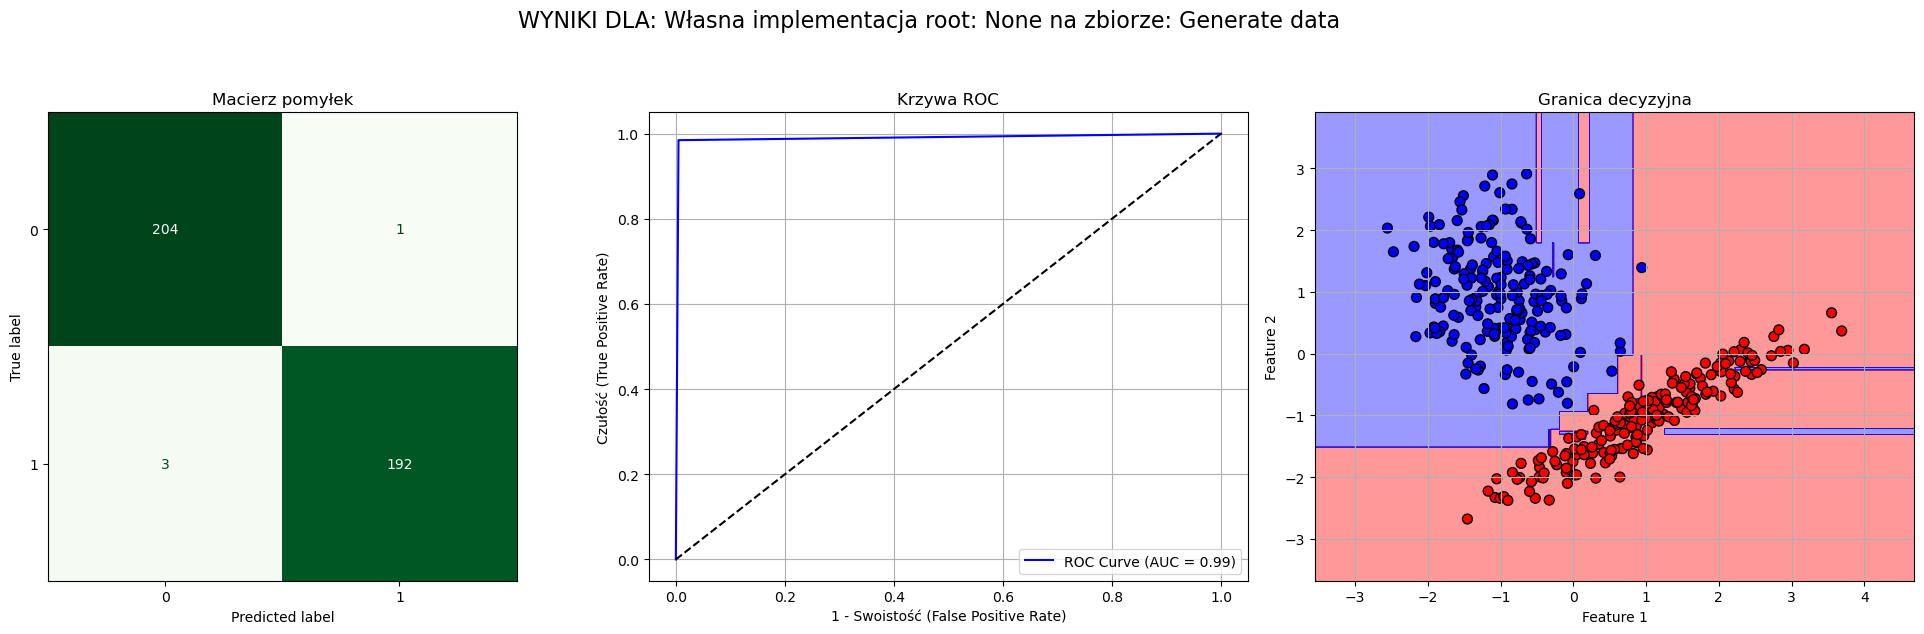

Sklearn root: None na Generate data:
Skuteczność: 98.7500%
Czułość (Recall): 98.9744%
Swoistość: 98.5366%
ROC AUC: 0.9876


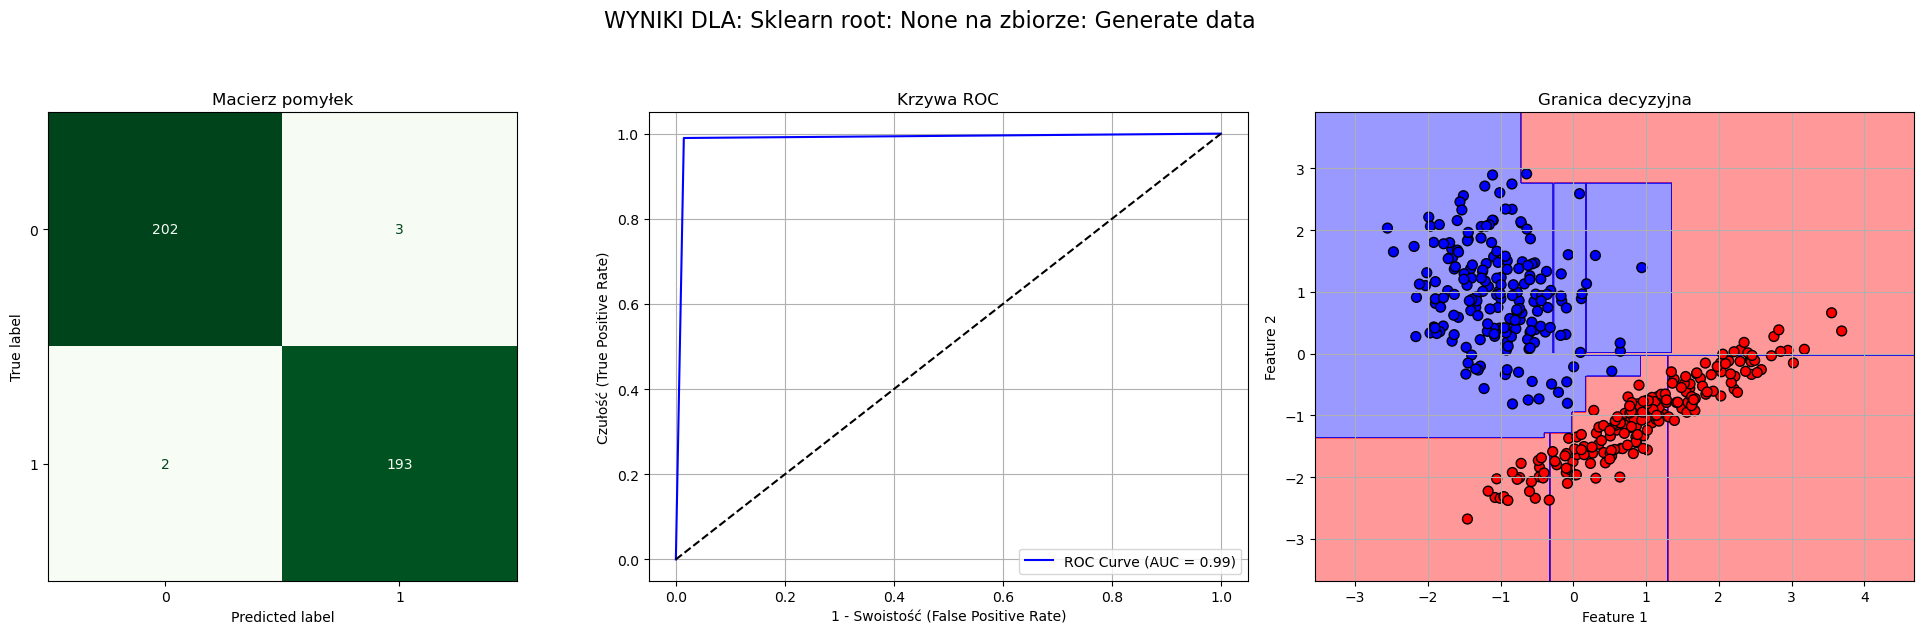

Drzewo decyzyjne dla głebokości: 2
Własna implementacja root: 2 na Generate data:
Skuteczność: 93.7500%
Czułość (Recall): 87.1795%
Swoistość: 100.0000%
ROC AUC: 0.9359


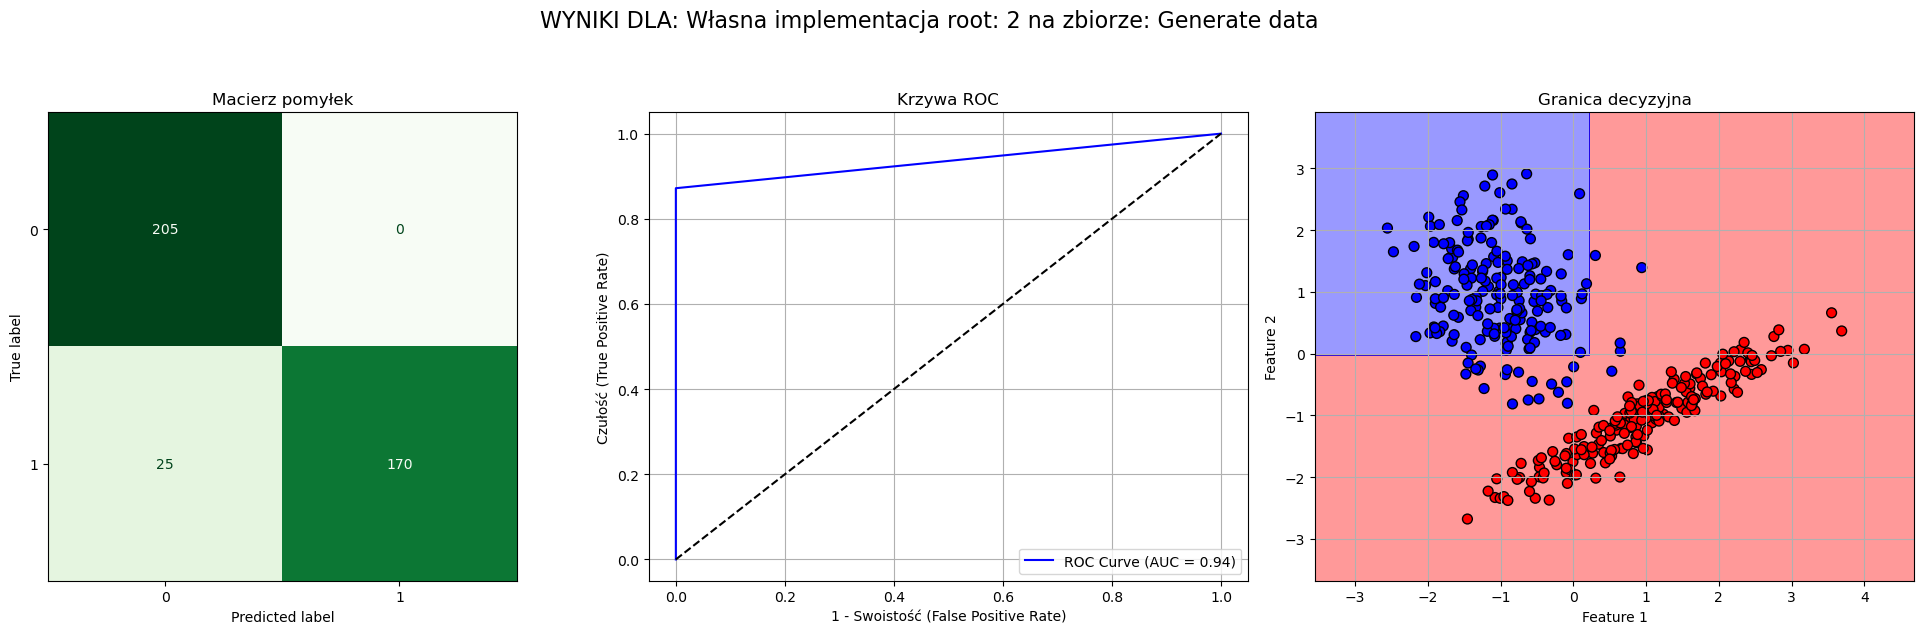

Sklearn root: 2 na Generate data:
Skuteczność: 94.7500%
Czułość (Recall): 89.2308%
Swoistość: 100.0000%
ROC AUC: 0.9462


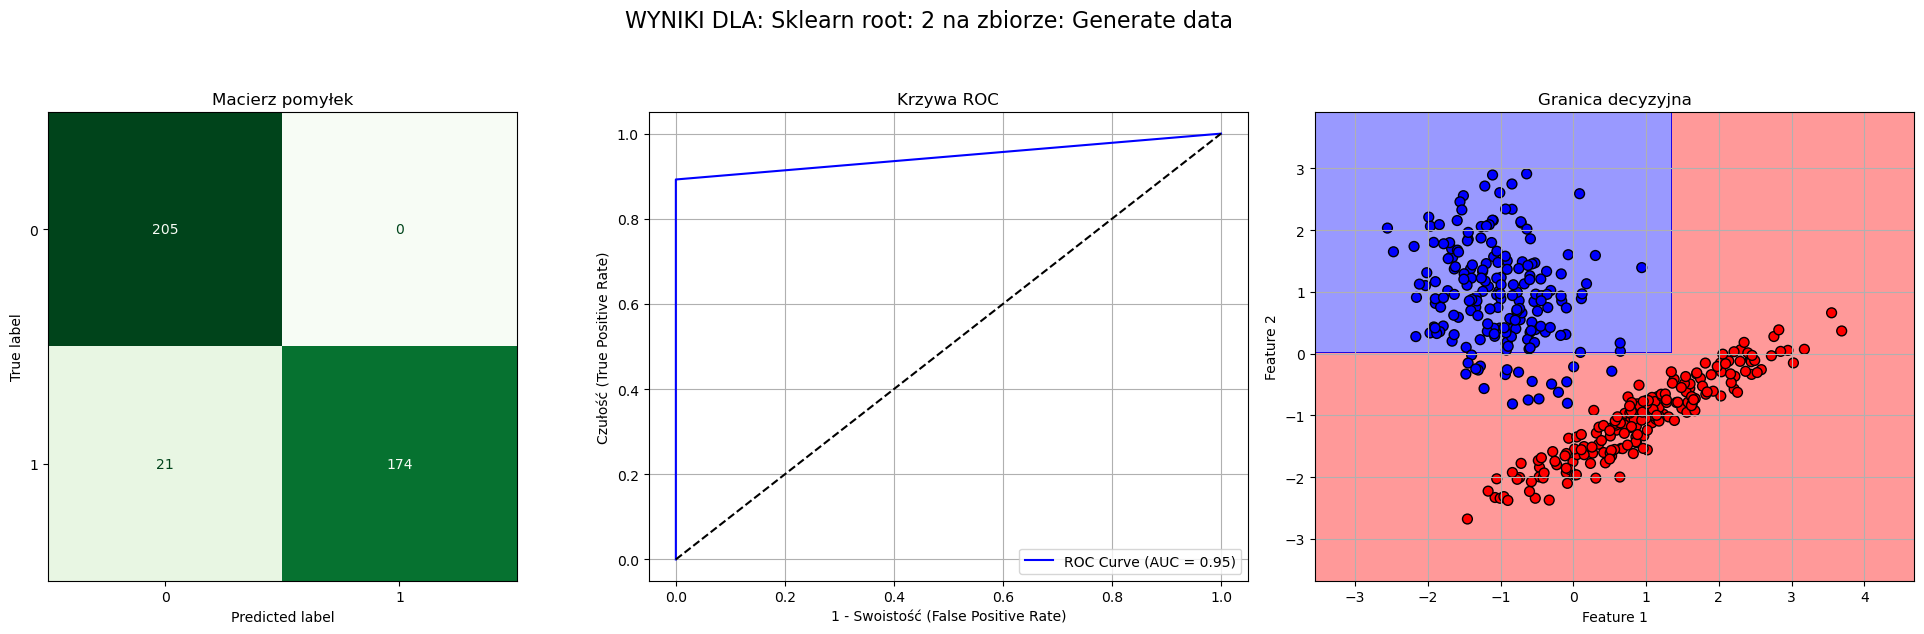

In [73]:
results = {}

X_generate, y_generate = generate_data(2000, 2, 259195)
X_gen_train, X_gen_test, y_gen_train, y_gen_test = train_test_split(X_generate, y_generate, test_size=0.2, random_state=259195)

depths = [None, 2]
for depth in depths:
    print(f"Drzewo decyzyjne dla głebokości: {depth}")
    model = DecisionTree(max_depth=depth)
    model.fit(X_gen_train, y_gen_train)
    # model.print_tree()
    y_pred = model.predict(X_gen_test)
    evaluate_classifier(y_gen_test, y_pred, X_gen_test, y_gen_test, model, f"Własna implementacja root: {depth}", "Generate data", labels=[0,1])

    sk_model = SkDecisionTree(max_depth=depth)
    sk_model.fit(X_gen_train, y_gen_train)
    y_sk_pred = sk_model.predict(X_gen_test)
    evaluate_classifier(y_gen_test, y_sk_pred, X_gen_test, y_gen_test, sk_model, f"Sklearn root: {depth}", "Generate data", labels=[0,1])

#### Dla *make moons*:

Drzewo decyzyjne dla głebokości: None
Własna implementacja root: None na Moons data:
Skuteczność: 99.5000%
Czułość (Recall): 100.0000%
Swoistość: 99.0476%
ROC AUC: 0.9952


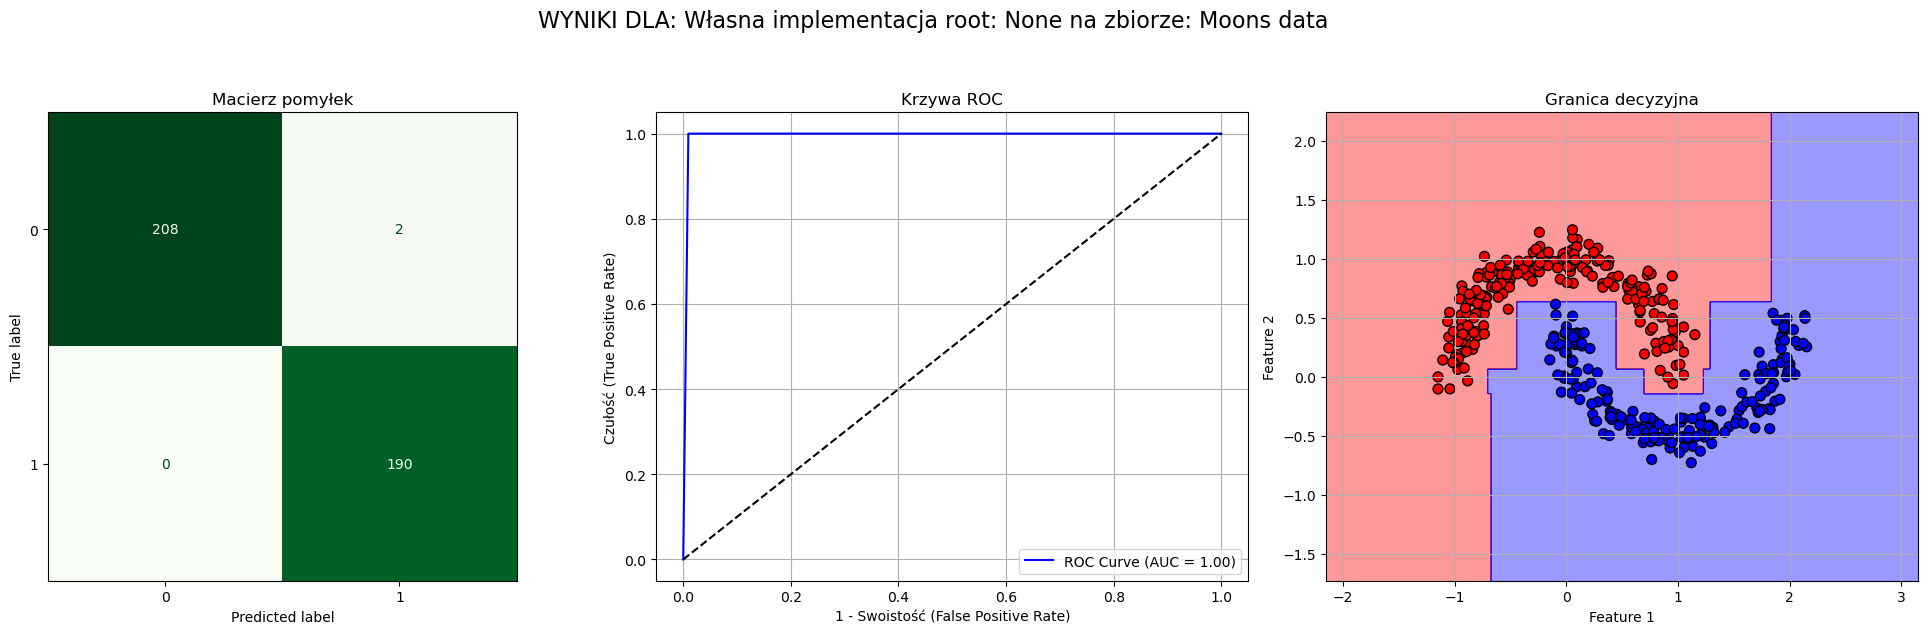

Sklearn root: None na Moons data:
Skuteczność: 99.5000%
Czułość (Recall): 99.4737%
Swoistość: 99.5238%
ROC AUC: 0.9950


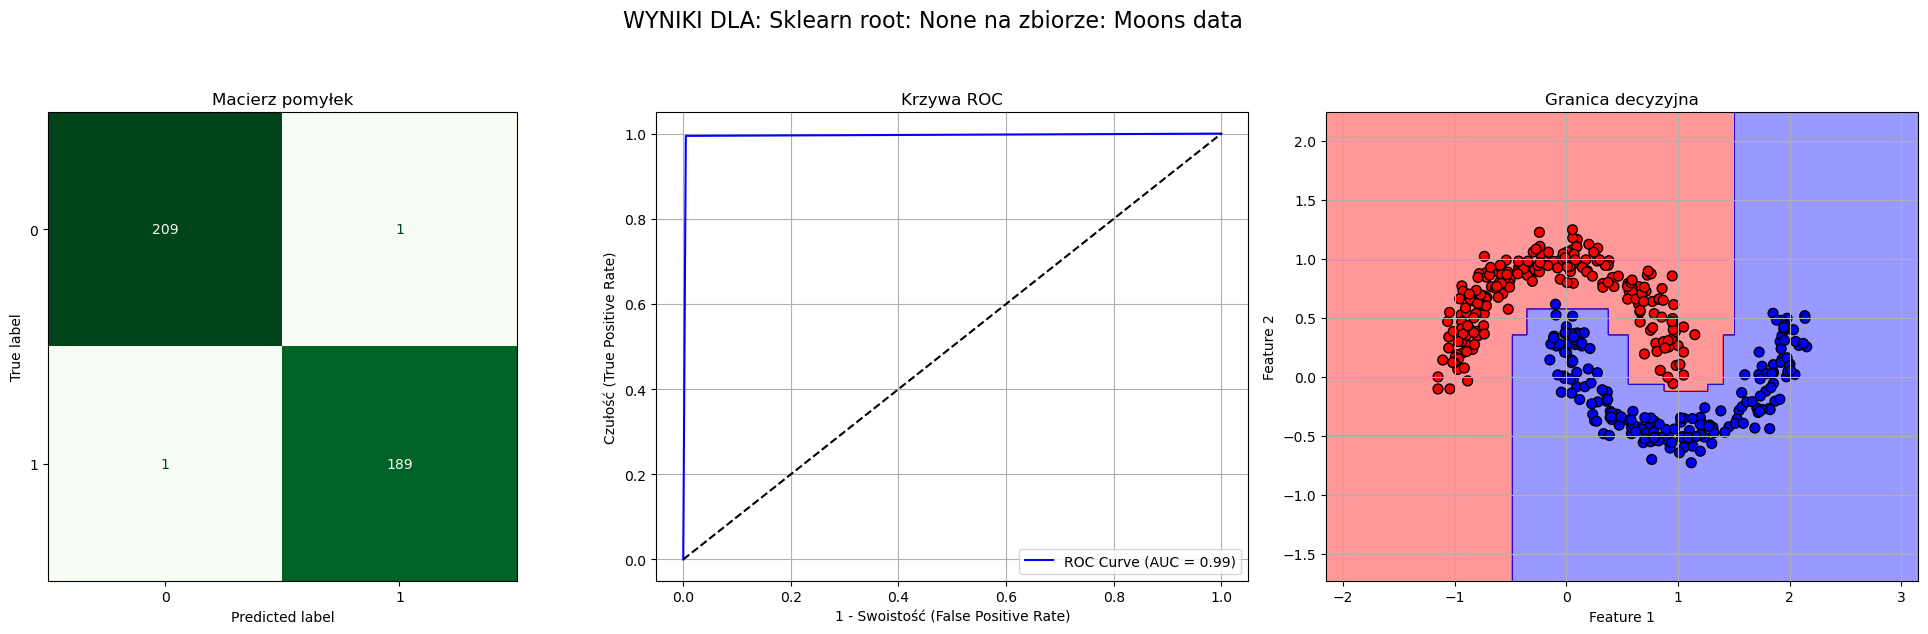

Drzewo decyzyjne dla głebokości: 2
Własna implementacja root: 2 na Moons data:
Skuteczność: 89.0000%
Czułość (Recall): 81.5789%
Swoistość: 95.7143%
ROC AUC: 0.8865


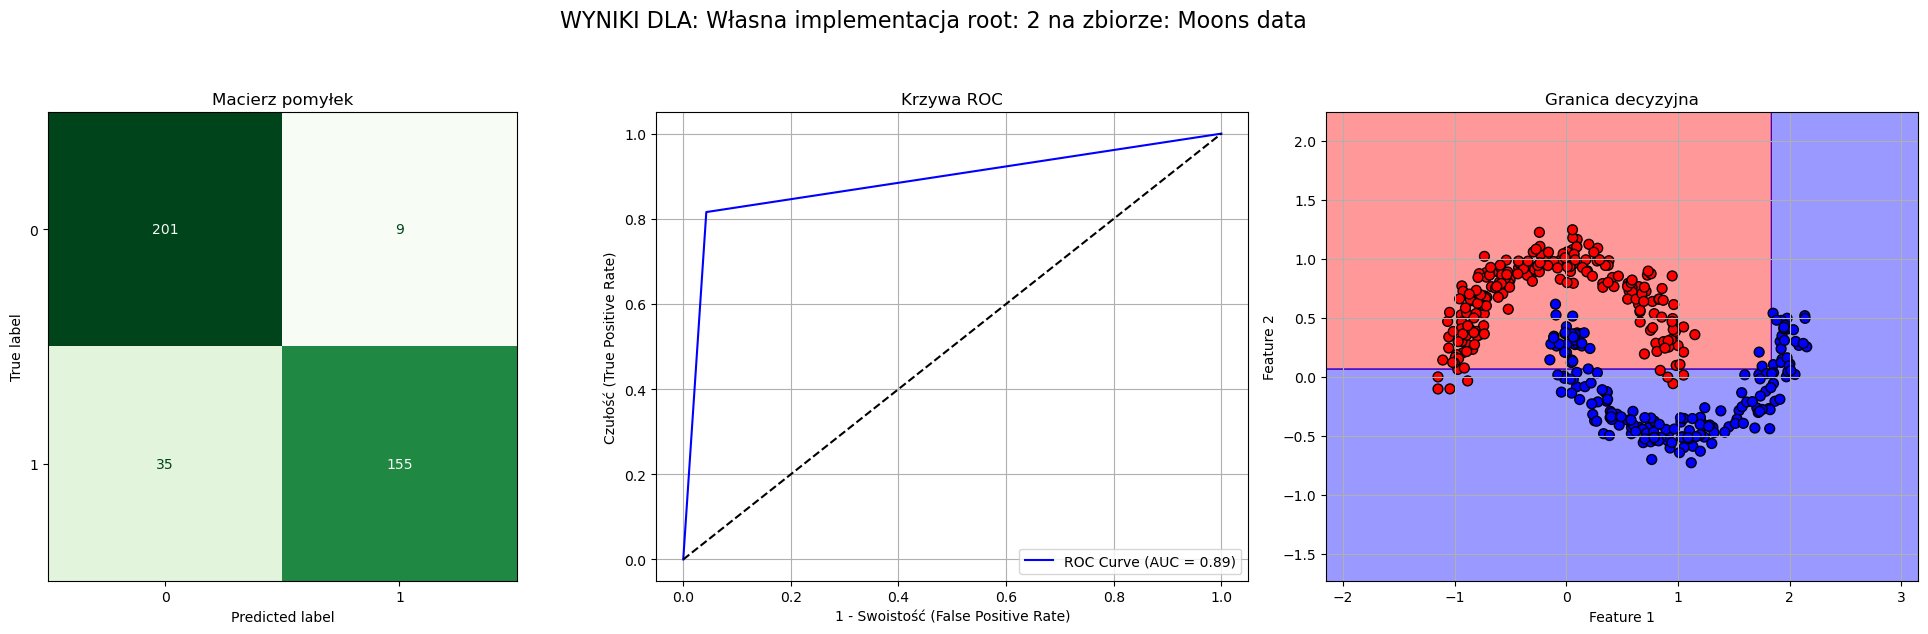

Sklearn root: 2 na Moons data:
Skuteczność: 92.7500%
Czułość (Recall): 93.6842%
Swoistość: 91.9048%
ROC AUC: 0.9279


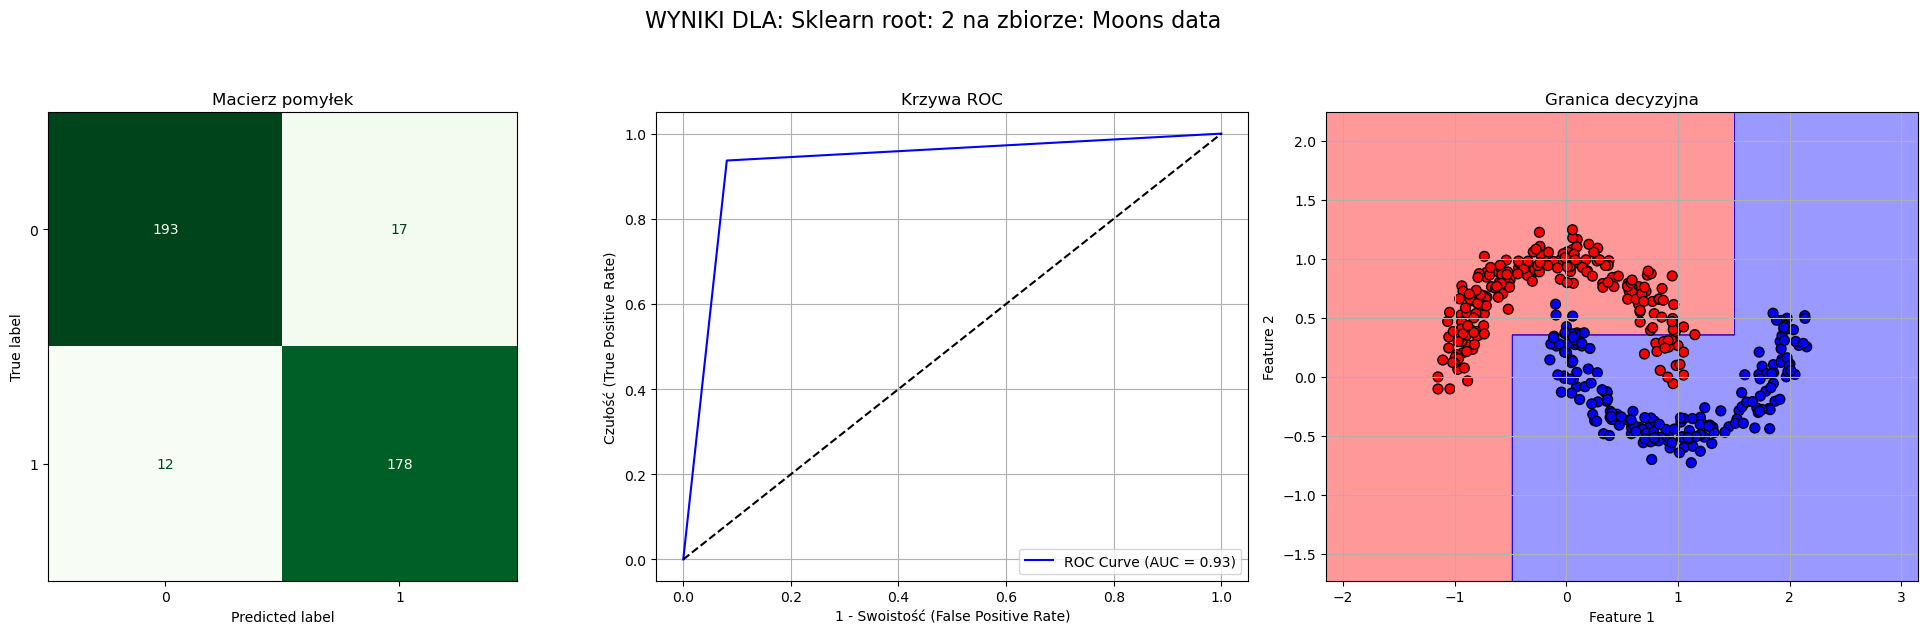

In [74]:
X_moons, y_moons = generate_moons(2000, 259195)
X_m_train, X_m_test, y_m_train, y_m_test = train_test_split(X_moons, y_moons, test_size=0.2, random_state=259195)

depths = [None, 2]
for depth in depths:
    print(f"Drzewo decyzyjne dla głebokości: {depth}")
    model = DecisionTree(max_depth=depth)
    model.fit(X_m_train, y_m_train)
    # model.print_tree()
    y_pred = model.predict(X_m_test)
    evaluate_classifier(y_m_test, y_pred, X_m_test, y_m_test, model, f"Własna implementacja root: {depth}", "Moons data", labels=[0,1])

    sk_model = SkDecisionTree(max_depth=depth)
    sk_model.fit(X_m_train, y_m_train)
    y_sk_pred = sk_model.predict(X_m_test)
    evaluate_classifier(y_m_test, y_sk_pred, X_m_test, y_m_test, sk_model, f"Sklearn root: {depth}", "Moons data", labels=[0,1])
    

#### Testowanie dla zbiorów wielomodowych:

[0 1 0 ... 0 1 1]
Drzewo decyzyjne dla głebokości: None
Własna implementacja root: None na Blobs data:
Skuteczność: 100.0000%
Czułość (Recall): 100.0000%
Swoistość: 100.0000%
ROC AUC: 1.0000


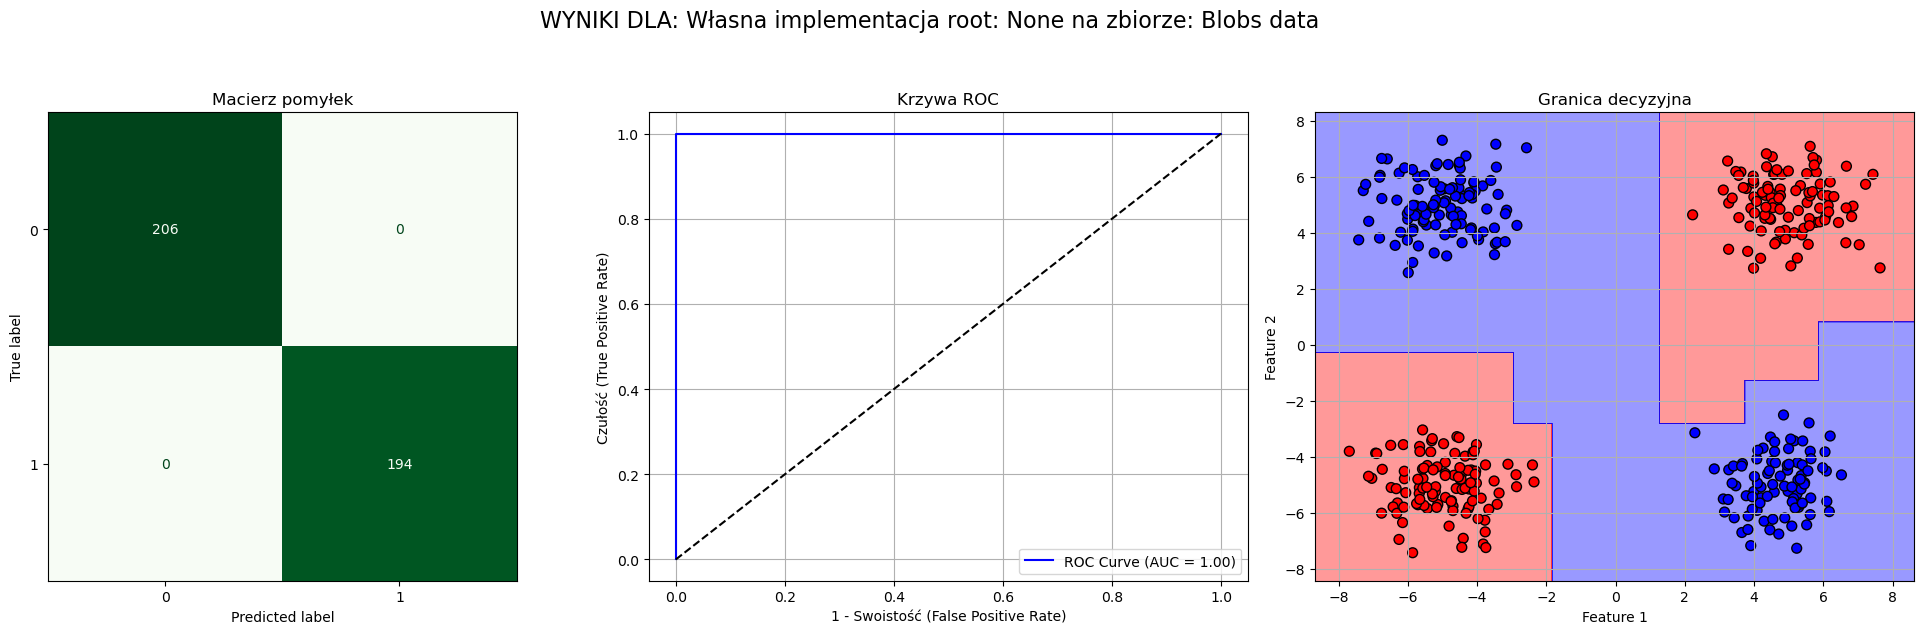

Sklearn root: None na Blobs data:
Skuteczność: 100.0000%
Czułość (Recall): 100.0000%
Swoistość: 100.0000%
ROC AUC: 1.0000


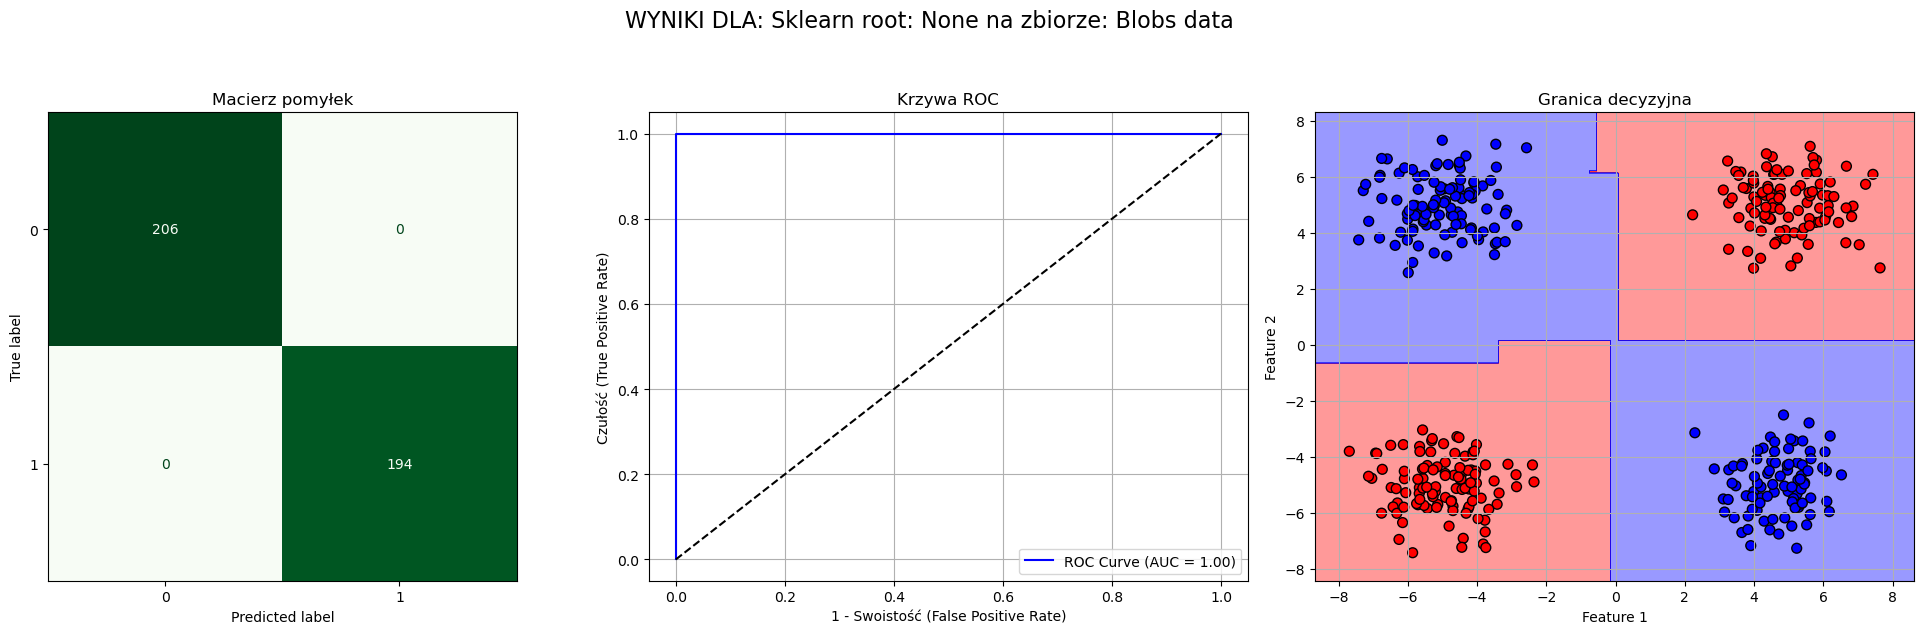

Drzewo decyzyjne dla głebokości: 2
Własna implementacja root: 2 na Blobs data:
Skuteczność: 60.7500%
Czułość (Recall): 59.7938%
Swoistość: 61.6505%
ROC AUC: 0.6072


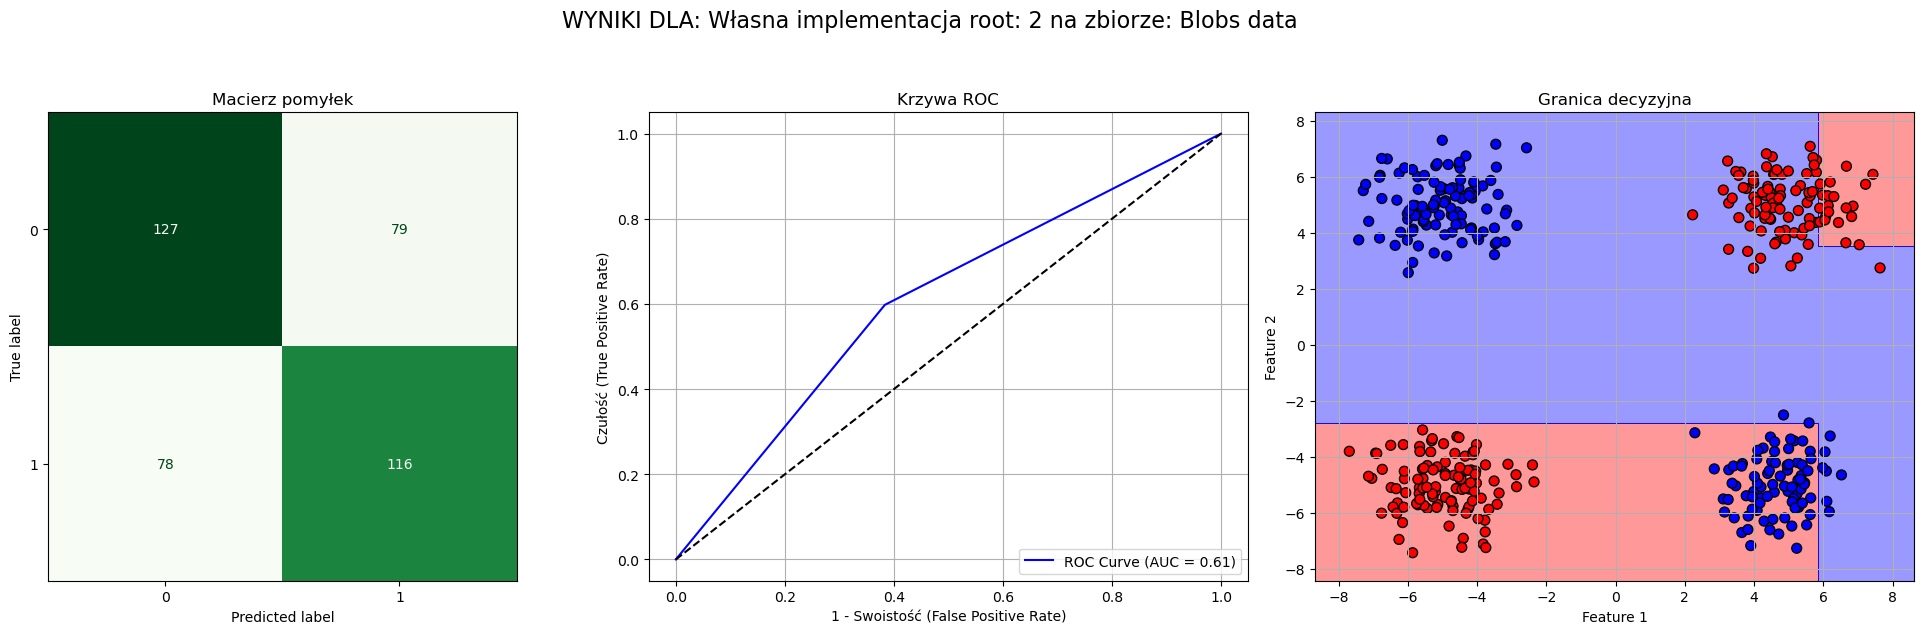

Sklearn root: 2 na Blobs data:
Skuteczność: 52.0000%
Czułość (Recall): 100.0000%
Swoistość: 6.7961%
ROC AUC: 0.5340


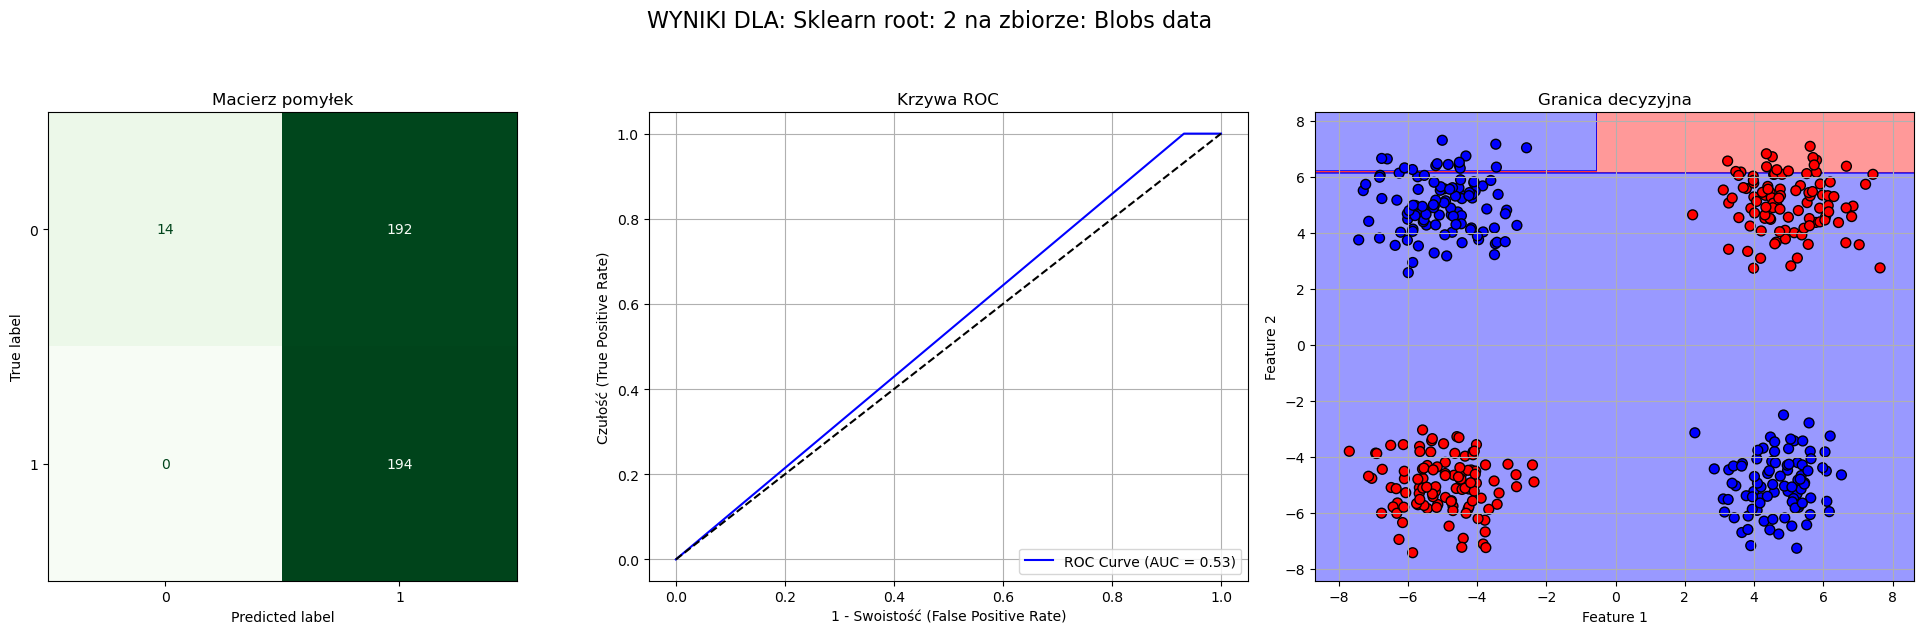

Drzewo decyzyjne dla głebokości: 4
Własna implementacja root: 4 na Blobs data:
Skuteczność: 98.5000%
Czułość (Recall): 96.9072%
Swoistość: 100.0000%
ROC AUC: 0.9845


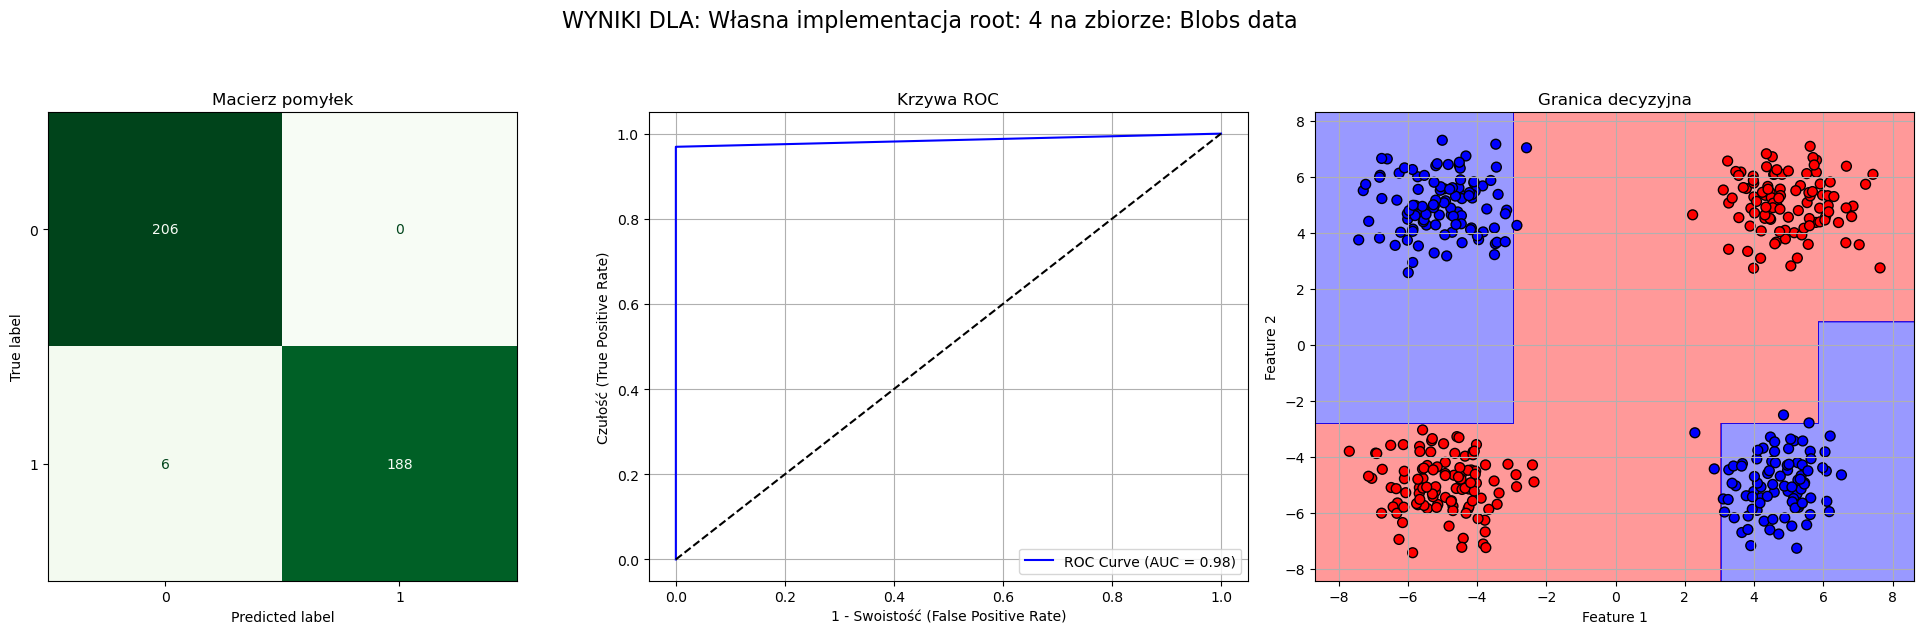

Sklearn root: 4 na Blobs data:
Skuteczność: 97.5000%
Czułość (Recall): 97.9381%
Swoistość: 97.0874%
ROC AUC: 0.9751


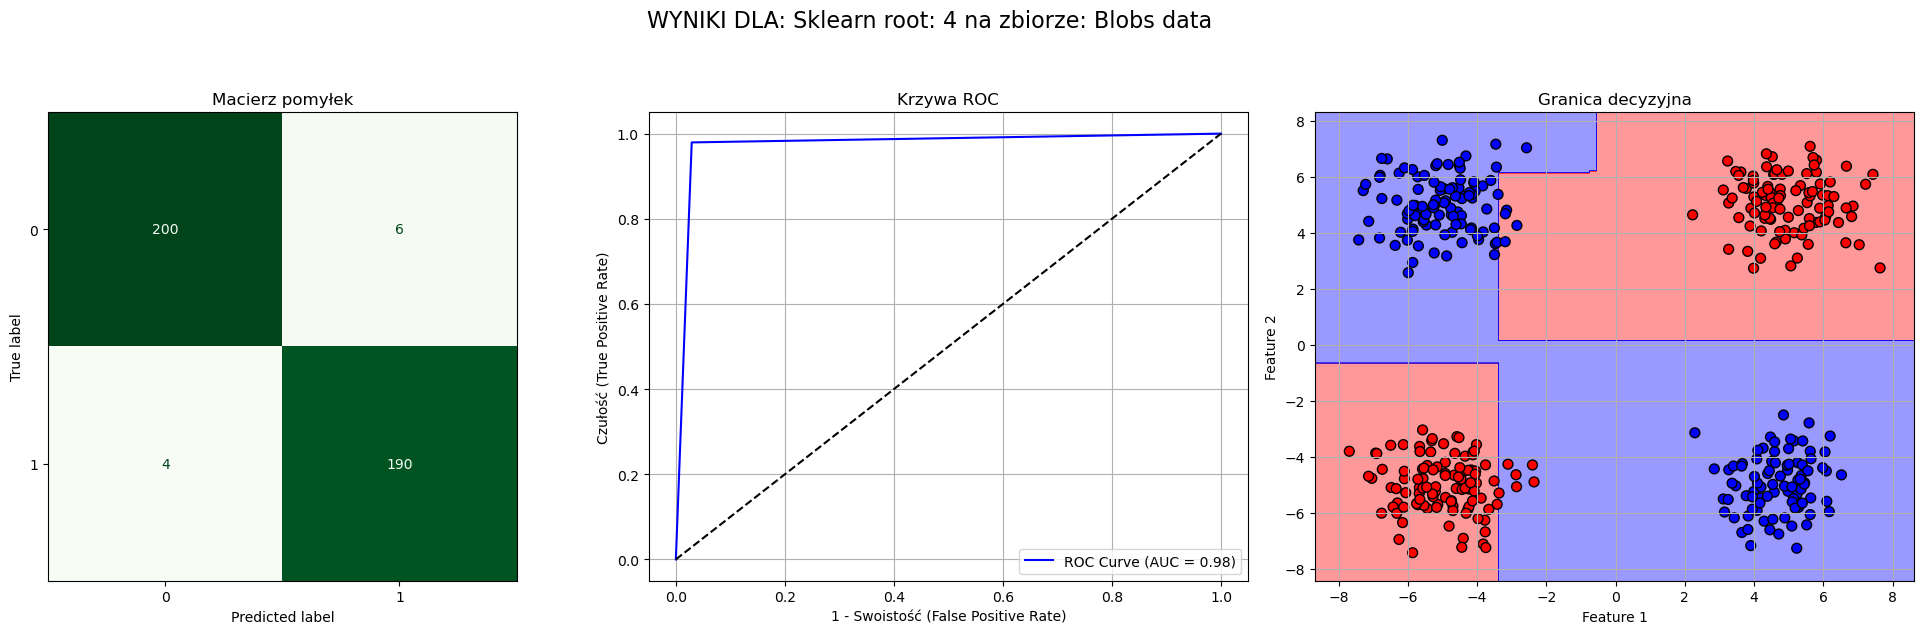

In [75]:
X_blobs, y_blobs = generate_blobs(2000, 2, 259195, split_data=[0, 3])
X_b_train, X_b_test, y_b_train, y_b_test = train_test_split(X_blobs, y_blobs, test_size=0.2, random_state=259195)

print(y_blobs)
depths = [None, 2, 4]
for depth in depths:
    print(f"Drzewo decyzyjne dla głebokości: {depth}")
    model = DecisionTree(max_depth=depth)
    model.fit(X_b_train, y_b_train)
    # model.print_tree()
    y_pred = model.predict(X_b_test)
    evaluate_classifier(y_b_test, y_pred, X_b_test, y_b_test, model, f"Własna implementacja root: {depth}", "Blobs data", labels=[0,1])
    
    sk_model = SkDecisionTree(max_depth=depth)
    sk_model.fit(X_b_train, y_b_train)
    y_sk_pred = sk_model.predict(X_b_test)
    evaluate_classifier(y_b_test, y_sk_pred, X_b_test, y_b_test, sk_model, f"Sklearn root: {depth}", "Blobs data", labels=[0,1])

#### Wyniki i obserwacje:

* Modele najlepiej uczą się przy ustalonej nieograniczonej głębokości drzewa.
* Najgorzej wypadają modele z głębokością równą 2
* W wielomodowych zbiorach modele dobrze wypadają dopiero przy głębokości równej ilości klastrów.